# Análisis de Interpretabilidad con SHAP (Valores Reales)

En esta notebook, utilizaremos la librería `shap` para interpretar las predicciones de nuestro modelo XGBoost optimizado. SHAP (SHapley Additive exPlanations) es un enfoque de teoría de juegos para explicar la salida de cualquier modelo de machine learning. Nos ayuda a entender cómo cada característica contribuye a la predicción del modelo.

**A diferencia de la notebook anterior, aquí ajustaremos las visualizaciones para mostrar los valores reales (sin escalar) de las características, facilitando así su interpretación directa.**

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import json
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#!pip install shap

In [3]:
# Cargar datos, características y modelo entrenado
processed_data_path = '../../data/processed/final_processed_data.parquet'
features_path = '../../data/processed/final_features.json'
model_path = '../../models/xgboost_tuned_pipeline.joblib'

df = pd.read_parquet(processed_data_path)
with open(features_path, 'r') as f:
    final_features = json.load(f)
best_model = joblib.load(model_path)

print("Datos, características y modelo cargados.")

Datos, características y modelo cargados.


In [4]:
# Preparar datos (usando la misma división que en el entrenamiento)
target_column = 'precio_mxn'
X = df[final_features]
y = df[target_column]

# Asegurarse de que no hay nulos
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# El explainer de SHAP necesita los datos transformados que ve el modelo XGBoost
scaler = best_model.named_steps['scaler']
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame para mantener los nombres de las columnas
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=final_features)

print("Datos de prueba preparados y escalados.")

Datos de prueba preparados y escalados.


In [5]:
# Inicializar el explainer de SHAP y calcular los valores SHAP
regressor = best_model.named_steps['regressor']

# Usamos TreeExplainer que es eficiente para modelos de árbol como XGBoost
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test_scaled_df)

print("Valores SHAP calculados para el conjunto de prueba.")

Valores SHAP calculados para el conjunto de prueba.


## Visualización de la Importancia Global de Características

El siguiente gráfico de barras muestra la importancia media absoluta de cada característica en el conjunto de datos. Es una alternativa a la `feature_importance_` de XGBoost. Este gráfico no se ve afectado por la escala de los datos, ya que solo muestra la magnitud del impacto.

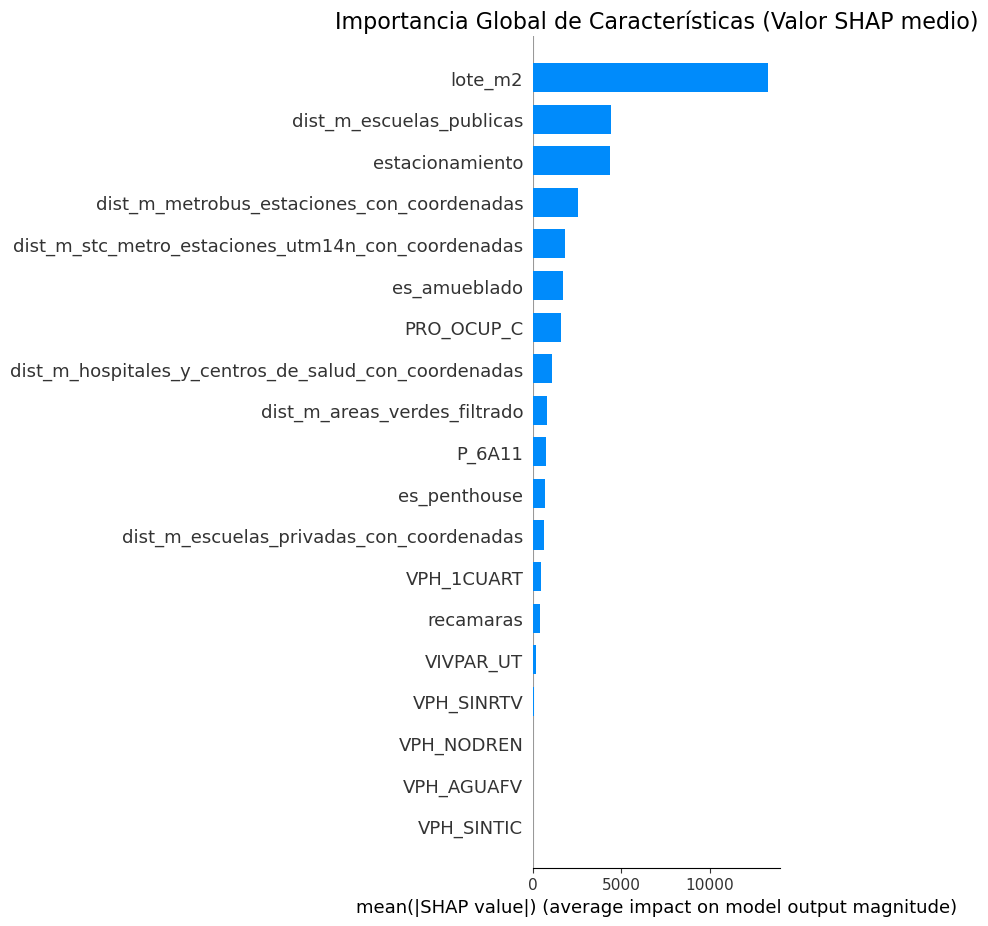

In [6]:
# Gráfico de resumen SHAP (gráfico de barras)
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", show=False)
plt.title("Importancia Global de Características (Valor SHAP medio)", fontsize=16)
plt.show()

## Visualización Detallada de la Importancia de Características

El gráfico de enjambre (beeswarm) es más informativo. Muestra no solo la importancia de cada característica, sino también el impacto de sus valores en la predicción. Cada punto es una observación:
- El **eje X** es el valor SHAP (el impacto en la predicción).
- El **color** representa el valor de la característica (rojo = alto, azul = bajo). Para que sea interpretable, usamos los datos originales (`X_test`) para el color.

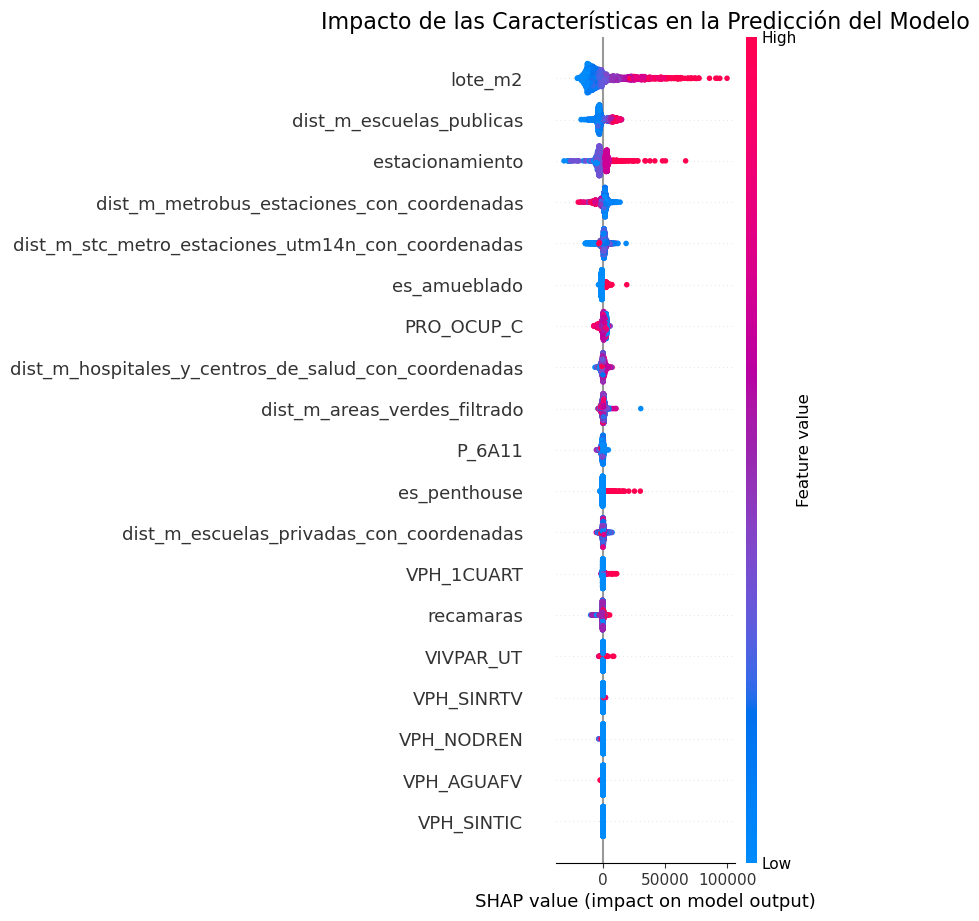

In [7]:
# Gráfico de resumen SHAP (beeswarm plot)
# Usamos X_test para que el color de los puntos refleje los valores originales y no los escalados.
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Impacto de las Características en la Predicción del Modelo", fontsize=16)
plt.show()

## Análisis de Dependencia de Características

Los gráficos de dependencia muestran cómo el valor de una sola característica afecta la predicción del modelo. También podemos ver efectos de interacción con otra característica (representada por el color).

Aquí es crucial usar `X_test` para que el eje X muestre los valores reales de la característica, no los escalados.

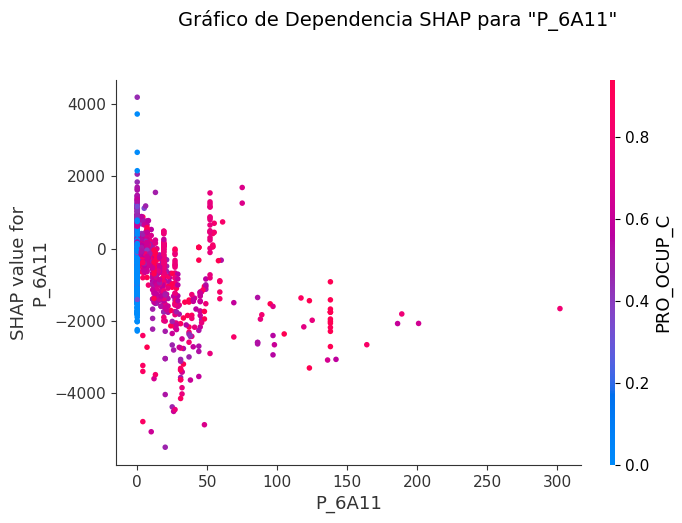

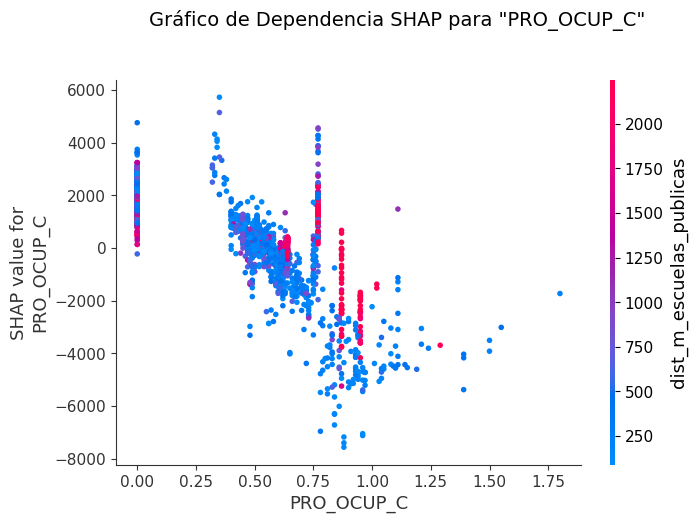

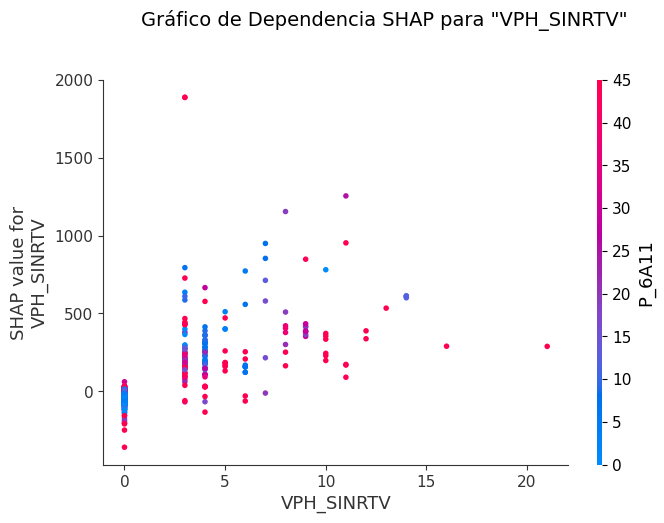

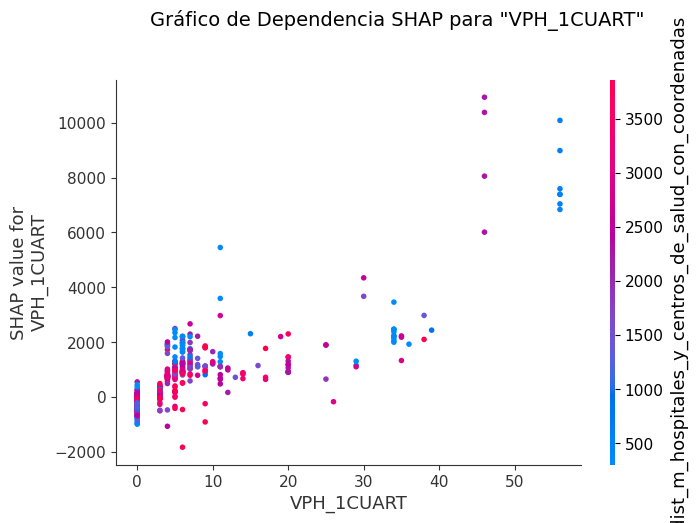

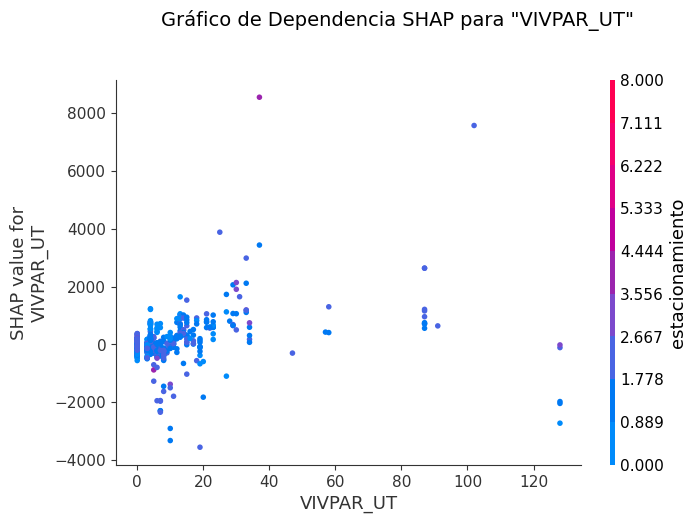

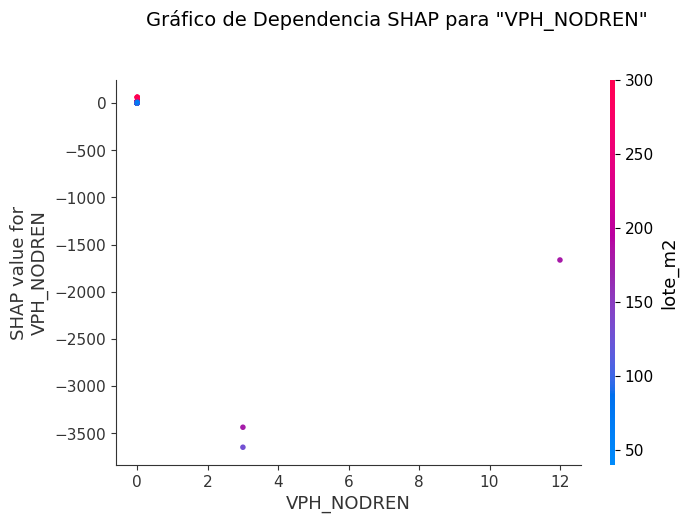

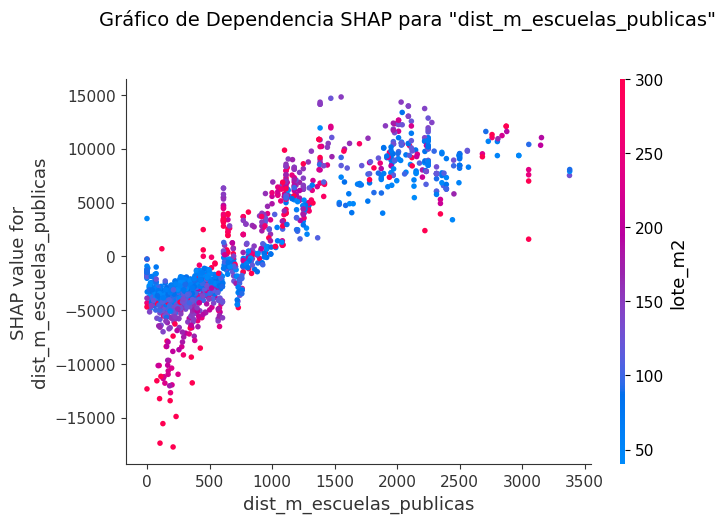

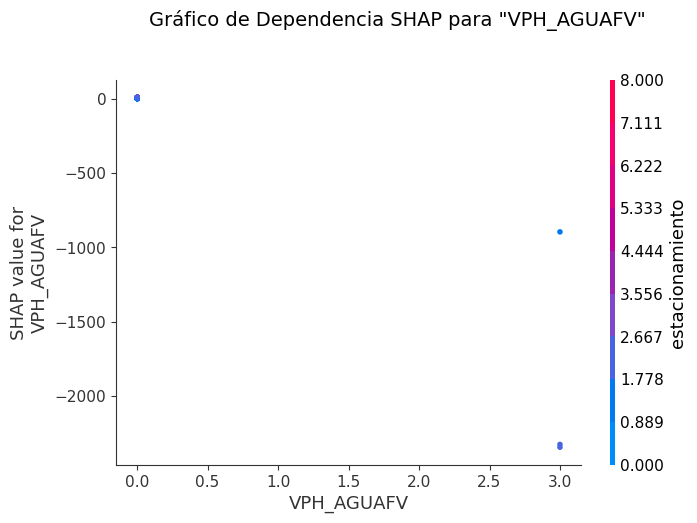

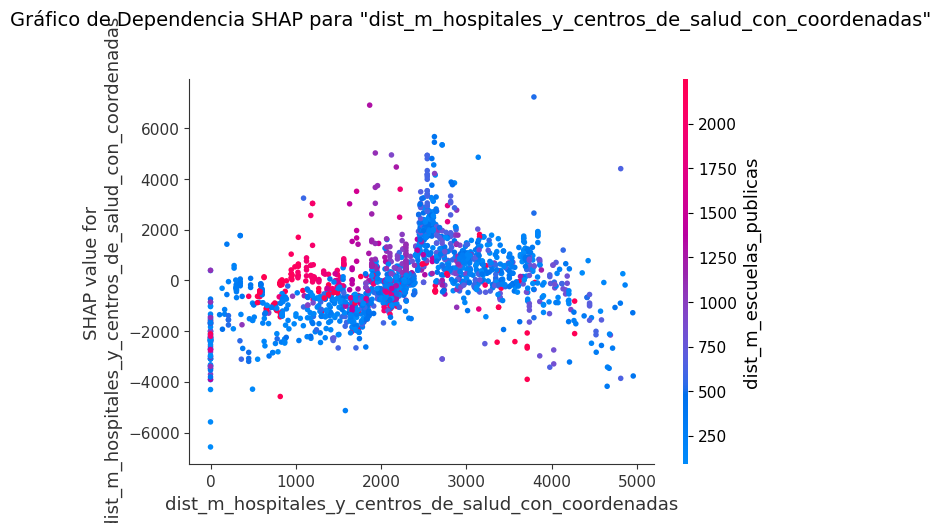

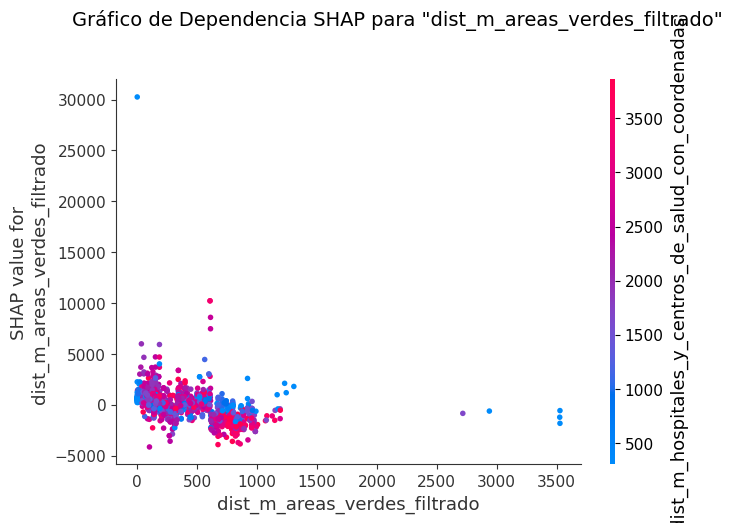

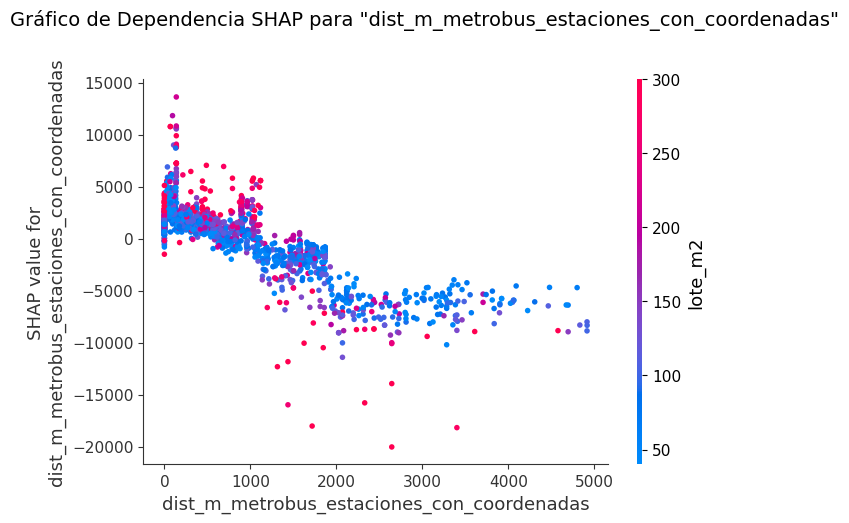

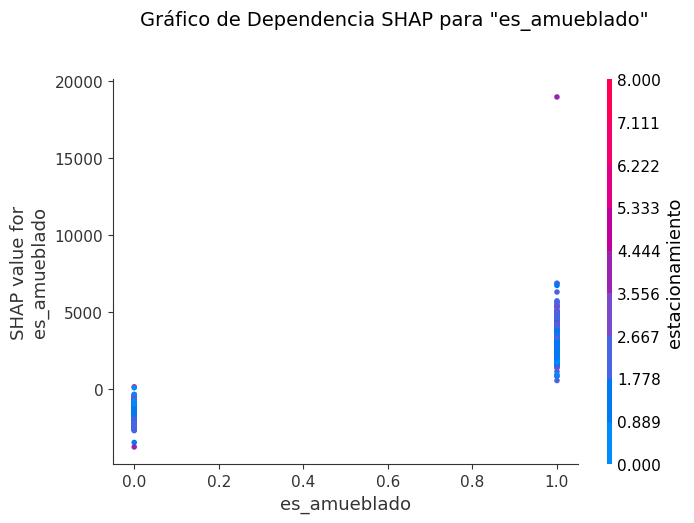

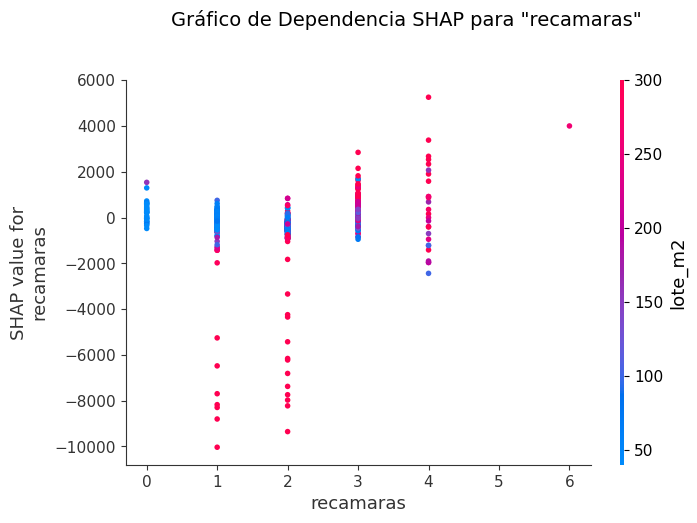

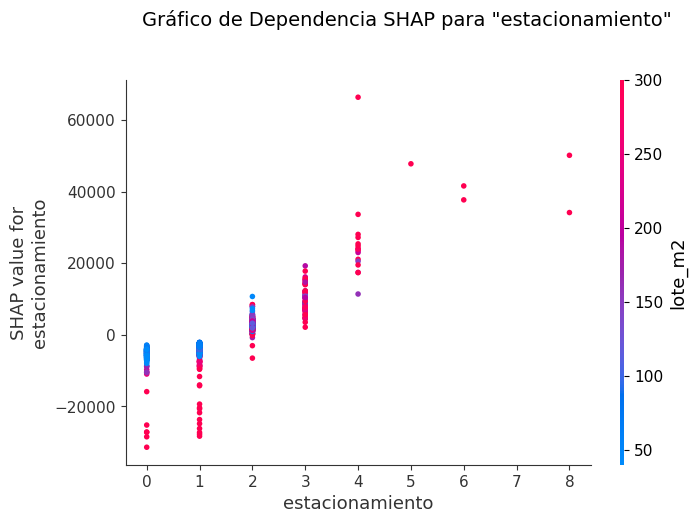

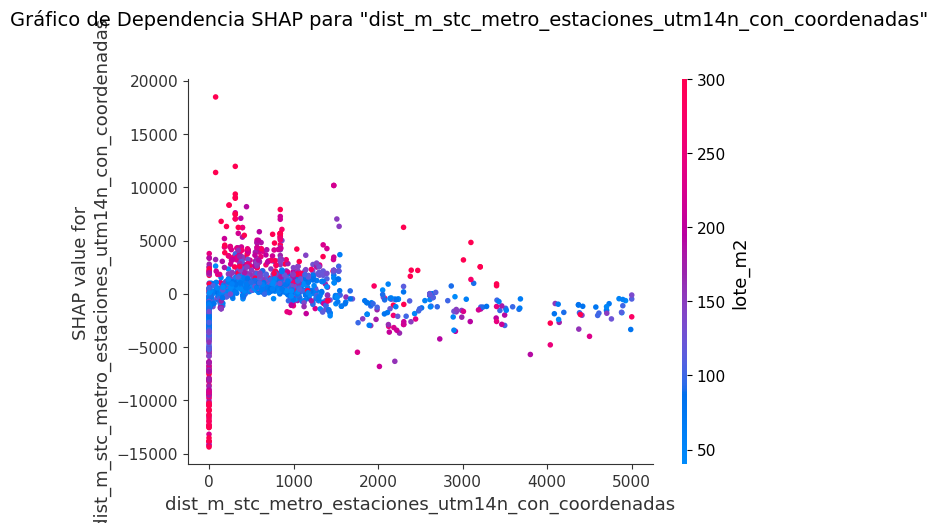

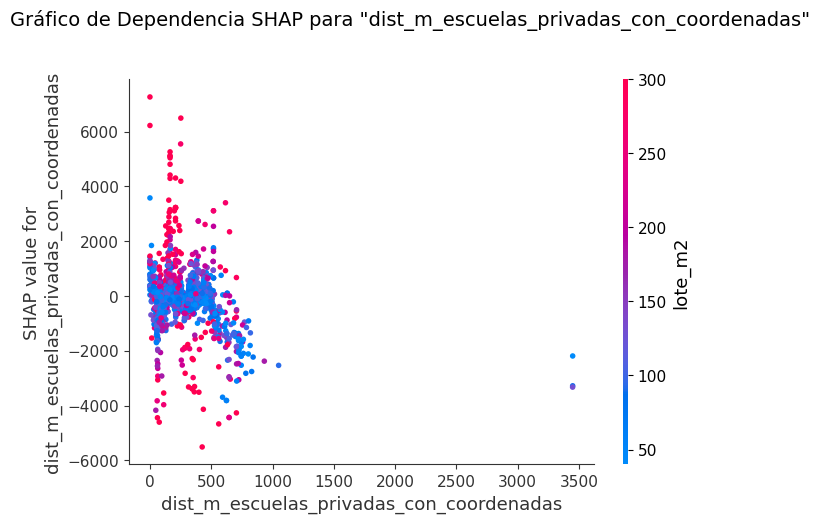

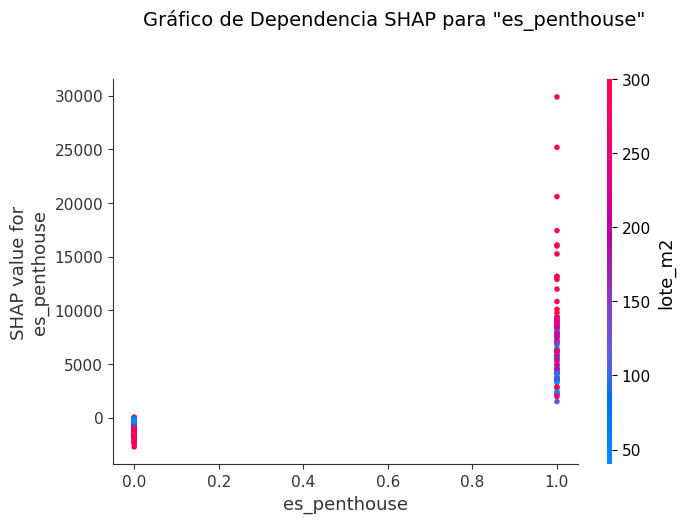

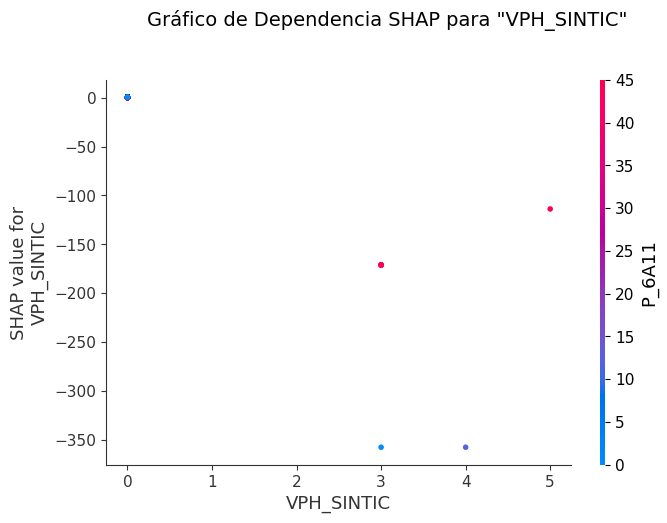

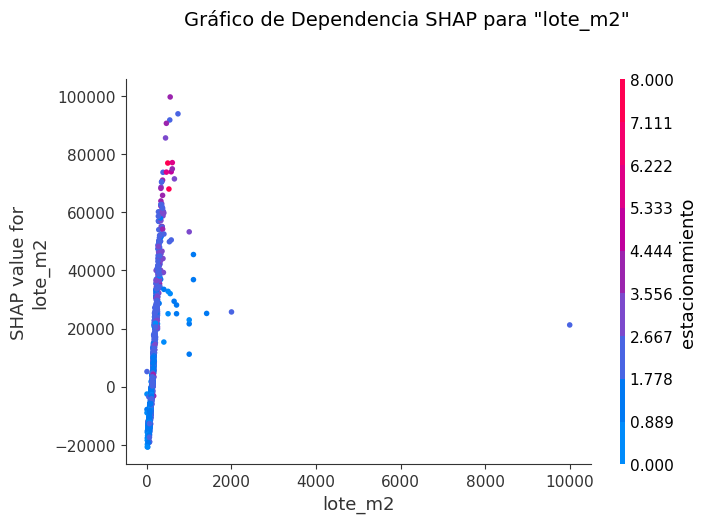

In [8]:
# Gráficos de dependencia para las características
for feature in final_features:
    # Usamos X_test para que el eje X muestre los valores originales de la característica
    shap.dependence_plot(feature, shap_values, X_test, interaction_index="auto", show=False)
    plt.suptitle(f'Gráfico de Dependencia SHAP para "{feature}"', y=1.02, fontsize=14)
    plt.show()

### Nota sobre la Interpretación de Gráficos con Datos Escalados

Es importante recordar que el modelo XGBoost opera sobre los **datos escalados**. Por lo tanto, los valores SHAP se calculan sobre estas características transformadas. 

Sin embargo, para facilitar la interpretación humana, en los gráficos anteriores (`summary_plot` y `dependence_plot`) hemos utilizado los **valores originales y sin escalar** de las características (`X_test`) para el color y los ejes. Esto nos permite entender el impacto de una característica en sus unidades originales (e.g., metros cuadrados, número de baños) sobre la predicción del modelo.

## Análisis de una Predicción Individual

Podemos usar un gráfico de cascada (waterfall) para explicar cómo se llega a una predicción específica. Muestra cómo cada característica empuja la predicción desde el valor base (la predicción media) hasta el valor final.

Para que sea interpretable, mostraremos los valores reales de las características para la instancia seleccionada.

Explicando la predicción para la instancia 0 del conjunto de prueba.
Valor real: 42,000.00 MXN
Predicción del modelo: 31,609.24 MXN


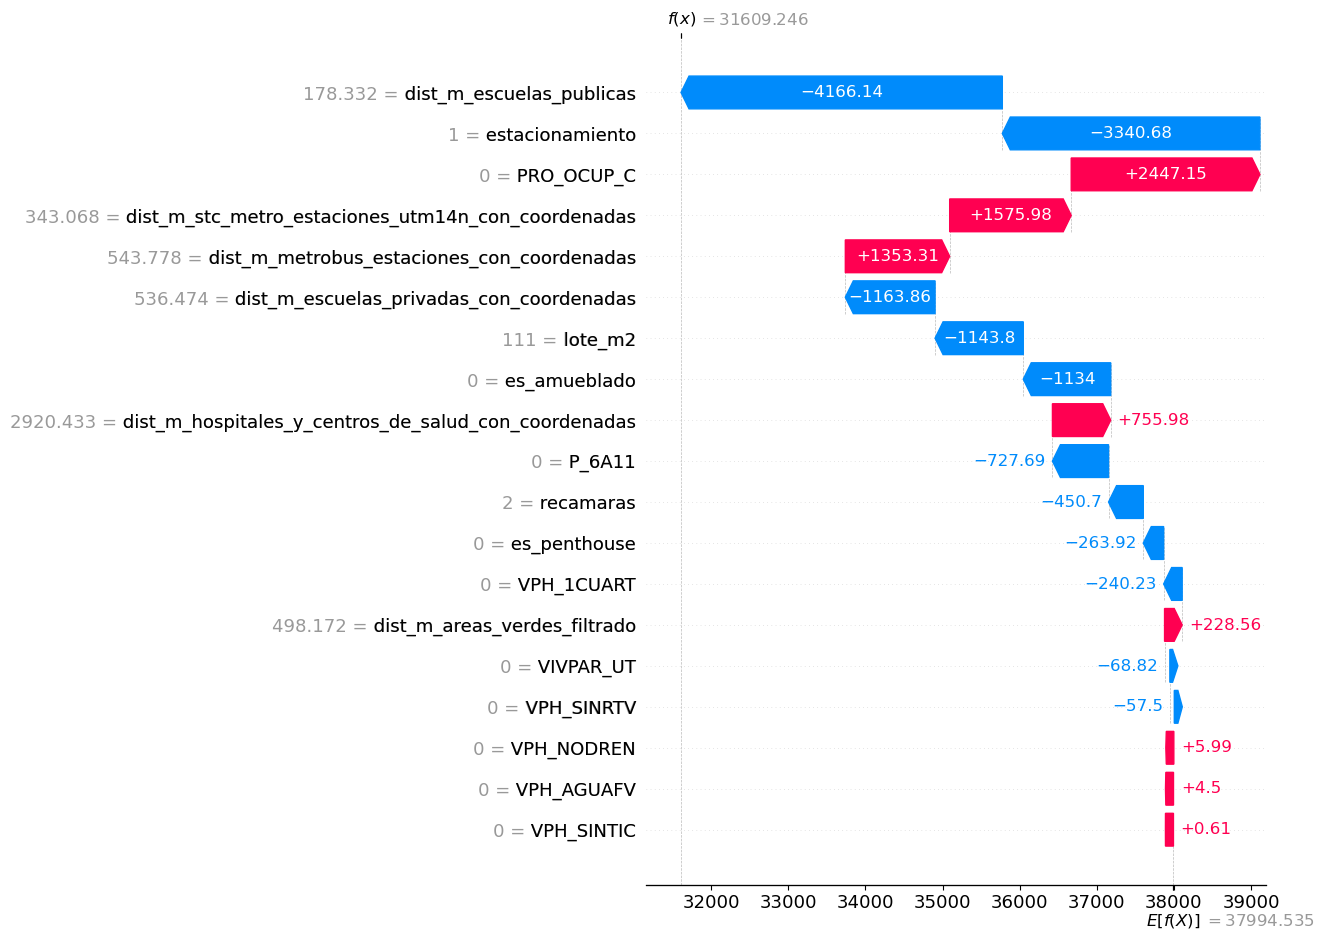

In [9]:
# Explicar una predicción individual (por ejemplo, la primera observación del conjunto de prueba)
shap.initjs()
instance_index = 0

print(f"Explicando la predicción para la instancia {instance_index} del conjunto de prueba.")
print(f"Valor real: {y_test.iloc[instance_index]:,.2f} MXN")
print(f"Predicción del modelo: {best_model.predict(X_test.iloc[[instance_index]])[0]:,.2f} MXN")

# El gráfico de cascada necesita el valor esperado (base) del explainer.
# Usamos X_test para mostrar los valores originales de las características, que son más interpretables.
shap.waterfall_plot(shap.Explanation(values=shap_values[instance_index], 
                                       base_values=explainer.expected_value, 
                                       data=X_test.iloc[instance_index], 
                                       feature_names=final_features), max_display=20)